In [14]:
%matplotlib inline

In [15]:
!conda install -y -c conda-forge zarr

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



## Package Plan ##

  environment location: /Users/seanfreeman/mambaforge/envs/aes690st-sp24-test

  added / updated specs:
    - zarr


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    zarr-2.17.2                |     pyhd8ed1ab_0         155 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         155 KB

The following packages will be UPDATED:

  zarr                                  2.17.1-pyhd8ed1ab_0 --> 2.17.2-pyhd8ed1ab_0 



                         

In [30]:
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import zarr
import numpy as np

In [17]:
#base_folder ='/share/share/sub-sevir/'
base_folder = '/Users/seanfreeman/Documents/Teaching/Spring_2024/'

In [18]:
training_ds = xr.open_dataset(base_folder+"/sub-sevir/sub-sevir-train.zarr", engine='zarr')

In [19]:
training_ds

<xarray.Dataset>
Dimensions:         (n_samples: 60000, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2018-08-25T00:15:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

In [20]:
one_sample = training_ds.isel(n_samples=0)

In [21]:
one_sample

<xarray.Dataset>
Dimensions:         (x: 48, y: 48, n_channel: 4)
Coordinates:
    id              object ...
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
    n_samples       datetime64[ns] 2018-08-25T00:15:00
Dimensions without coordinates: x, y
Data variables:
    features        (x, y, n_channel) float32 ...
    label_1d_class  int8 ...
    label_1d_reg    int16 ...
    label_2d_class  (x, y) int8 ...
    label_2d_reg    (x, y) int16 ...

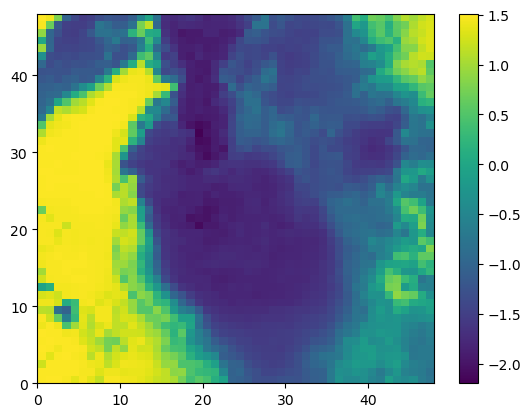

In [22]:
plt.pcolormesh(one_sample['features'][:, :, 1])
plt.colorbar()

In [23]:
two_sample = training_ds.isel(n_samples=[0,1], n_channel=[1])

In [35]:
two_sample.features.values[0].shape

(48, 48, 1)

In [25]:
ds_two_sample = tf.data.Dataset.from_tensor_slices((two_sample.features.values,two_sample.label_1d_class.values))


In [51]:
tf.keras.backend.clear_session()
keras.utils.set_random_seed(1)
input1 = keras.layers.Input(shape=two_sample.features.values[0].shape)
input_pool = keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(input1)
model_pool = keras.models.Model(inputs=[input1], outputs=[input_pool])
model_pool.compile(optimizer=keras.optimizers.legacy.Adam(), loss='mean_squared_error')
model_pool.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 1)         0         
 D)                                                              
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
out_pool = model_pool.predict(two_sample.features.values)

1/1 [==============================] - 0s 37ms/step


In [53]:
out_pool.shape

(2, 24, 24, 1)

In [54]:
two_sample.features.values[0].shape, out_pool[0].shape

((48, 48, 1), (24, 24, 1))

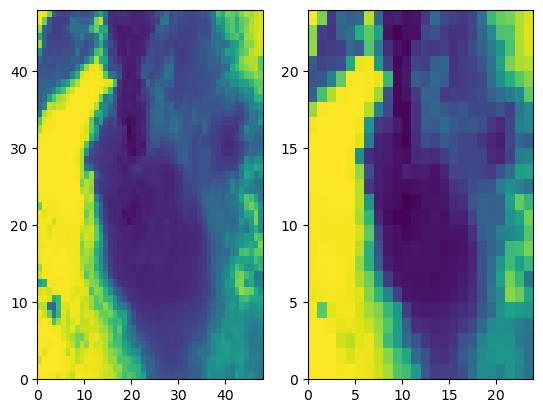

In [57]:
fig, axes = plt.subplots(1,2)
axes[0].pcolormesh(two_sample.features.values[0,:,:,0])

axes[1].pcolormesh(out_pool[0, :, :, 0])